In [1]:
import hydra
from glob import  glob
from proteoscope.datamodule import ProteoscopeDataModule
from proteoscope.cytoselfmodule import CytoselfLightningModule
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt



# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-02/18-43-45" # 6 epochs 
BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-03/05-45-38" # 21 epochs 
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)


    pdm = ProteoscopeDataModule(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
    )
    pdm.setup()

    clm = CytoselfLightningModule.load_from_checkpoint(
        chkpt,
        module_config=config.module,
        num_class=pdm.num_class,
    )

    clm.model.to('cuda')
    clm.model.eval()

/opt/conda/envs/pytorch/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
/tmp/ipykernel_24661/2438591544.py:15: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs-proteoscope/2023-08-03/05-45-38/checkpoints/last.ckpt


/home/ec2-user/proteoscope/proteoscope/datamodule.py:36: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  self.labels = pd.read_csv(self.labels_path, index_col=0)
/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


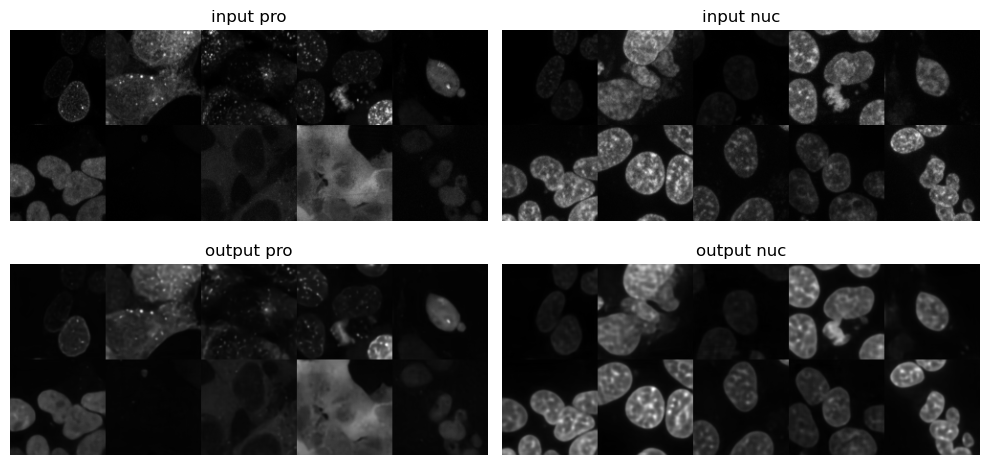

In [2]:
batch = next(iter(pdm.val_dataloader(novel_proteins=False, shuffle=True)))
input_images = batch['image'].to('cuda')
output_images, output_logits = clm.model(input_images)
output_images = output_images.detach().cpu().numpy()
input_images = input_images.detach().cpu().numpy()


data_ch = ['pro', 'nuc']
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(input_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(output_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
# fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [ ]:
dl = pdm.val_dataloader(novel_proteins=False, shuffle=False)

In [24]:
pdm.train_dataset.labels = pdm.train_dataset.labels[pdm.train_dataset.labels['localization'] != '']
dl = pdm.train_dataloader()

In [6]:
import torch
from tqdm import tqdm


embeddings = []
localizations = []
complexes = []
complexes_fig = []
names = []
with torch.no_grad():
    for batch in tqdm(dl):
        emb = clm.model(batch['image'].to('cuda'), 'vqvec2')
        embeddings.append(emb.detach().cpu().numpy())
        localizations.append(batch['localization'])
        complexes.append(batch['complex'])
        complexes_fig.append(batch['complex_fig'])
        names.append(batch['name'])
complexes = np.concatenate(complexes, axis=0)
complexes_fig = np.concatenate(complexes_fig, axis=0)
localizations = np.concatenate(localizations, axis=0)
embeddings = np.concatenate(embeddings, axis=0)
names = np.concatenate(names, axis=0)

100%|██████████| 11479/11479 [08:18<00:00, 23.01it/s]


In [2]:
import zarr
from os.path import join
import numpy as np

datapath = "/home/ec2-user/cytoself-data/"
zarr_path = join(datapath, "good_embeddings_redo21.zarr")

# shape = embeddings.shape
# chunks = (100, None, None, None)
# z = zarr.open(zarr_path, mode="a", shape=shape, chunks=chunks)
# z[:] = embeddings

# np.save(join(datapath, "good_localizations_redo21.npy"), localizations)
# np.save(join(datapath, "good_names_redo21.npy"), names)
# np.save(join(datapath, "good_complexes_redo21.npy"), complexes)
# np.save(join(datapath, "good_complexes_fig_redo21.npy"), complexes_fig)
embeddings = np.asarray(zarr.open(zarr_path, mode='r'))
localizations = np.load(join(datapath, "good_localizations_redo21.npy"))
names = np.load(join(datapath, "good_names_redo21.npy"))
complexes = np.load(join(datapath, "good_complexes_redo21.npy"))
complexes_fig = np.load(join(datapath, "good_complexes_fig_redo21.npy"))


In [3]:
import zarr
from os.path import join
import numpy as np

datapath = "/home/ec2-user/cytoself-data/"
zarr_path = join(datapath, "good_embeddings_redo21_train.zarr")

# shape = embeddings.shape
# chunks = (100, None, None, None)
# z = zarr.open(zarr_path, mode="a", shape=shape, chunks=chunks)
# z[:] = embeddings

# np.save(join(datapath, "good_localizations_redo21_train.npy"), localizations)
# np.save(join(datapath, "good_names_redo21_train.npy"), names)
# np.save(join(datapath, "good_complexes_redo21_train.npy"), complexes)
# np.save(join(datapath, "good_complexes_fig_redo21_train.npy"), complexes_fig)
embeddings_train = np.asarray(zarr.open(zarr_path, mode='r'))
localizations_train = np.load(join(datapath, "good_localizations_redo21_train.npy"))
names_train = np.load(join(datapath, "good_names_redo21_train.npy"))
complexes_train = np.load(join(datapath, "good_complexes_redo21_train.npy"))
complexes_fig_train = np.load(join(datapath, "good_complexes_fig_redo21_train.npy"))


In [9]:
# embeddings_train = embeddings
# localizations_train = localizations
# names_train = names
# complexes_train = complexes
# complexes_fig_train = complexes_fig

In [4]:
localizations[localizations == ''] = 'other'
complexes[complexes == ''] = 'other'
complexes_fig[complexes_fig == ''] = 'other'

In [5]:
localizations_train[localizations_train == ''] = 'other'
complexes_train[complexes_train == ''] = 'other'
complexes_fig_train[complexes_fig_train == ''] = 'other'

In [9]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer.fit(embeddings.reshape(embeddings.shape[0], -1))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [4]:
from joblib import dump
from joblib import load

#dump(reducer, join(datapath,'good_umap_model_redo21.joblib'))

reducer = load(join(datapath,'good_umap_model_redo21.joblib'))

In [5]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))
localizations[localizations == ''] = 'other'
complexes[complexes == ''] = 'other'
complexes_fig[complexes_fig == ''] = 'other'

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
label_colors = {
    'other': [188, 188, 188],
    'mitochondria':  [135, 38, 35],
    'nucleoplasm':  [146, 210, 243],
    'ER':  [218, 56, 50],
    'cytoplasm':  [128, 189, 93],
    'vesicles':  [199, 175, 78],
    'nuclear_membrane':  [40, 63, 149],
    'nucleolus':  [93, 139, 198],
    'Golgi':  [216, 46, 138],
    'nuclear_domains':  [64, 144, 147],
}
for key, values in label_colors.items():
    label_colors[key] = np.array(values) / 255

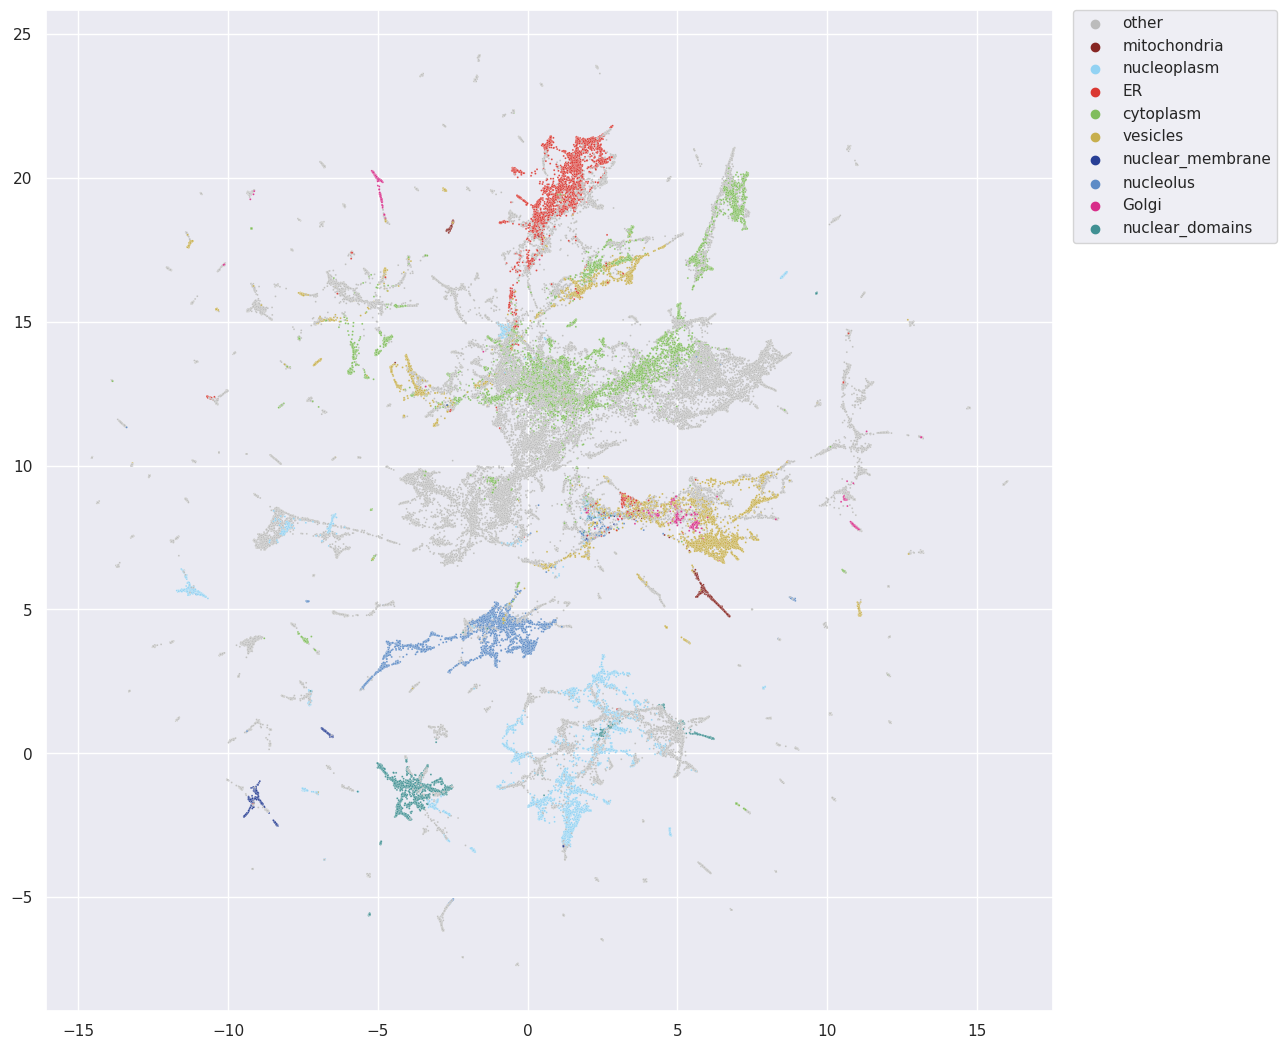

In [11]:
sns.set(rc={"figure.figsize":(13, 13)})
sns.scatterplot(x=reduced_embedding[:, 0], y=reduced_embedding[:, 1], hue=localizations, s=2, alpha=0.9, palette=label_colors)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

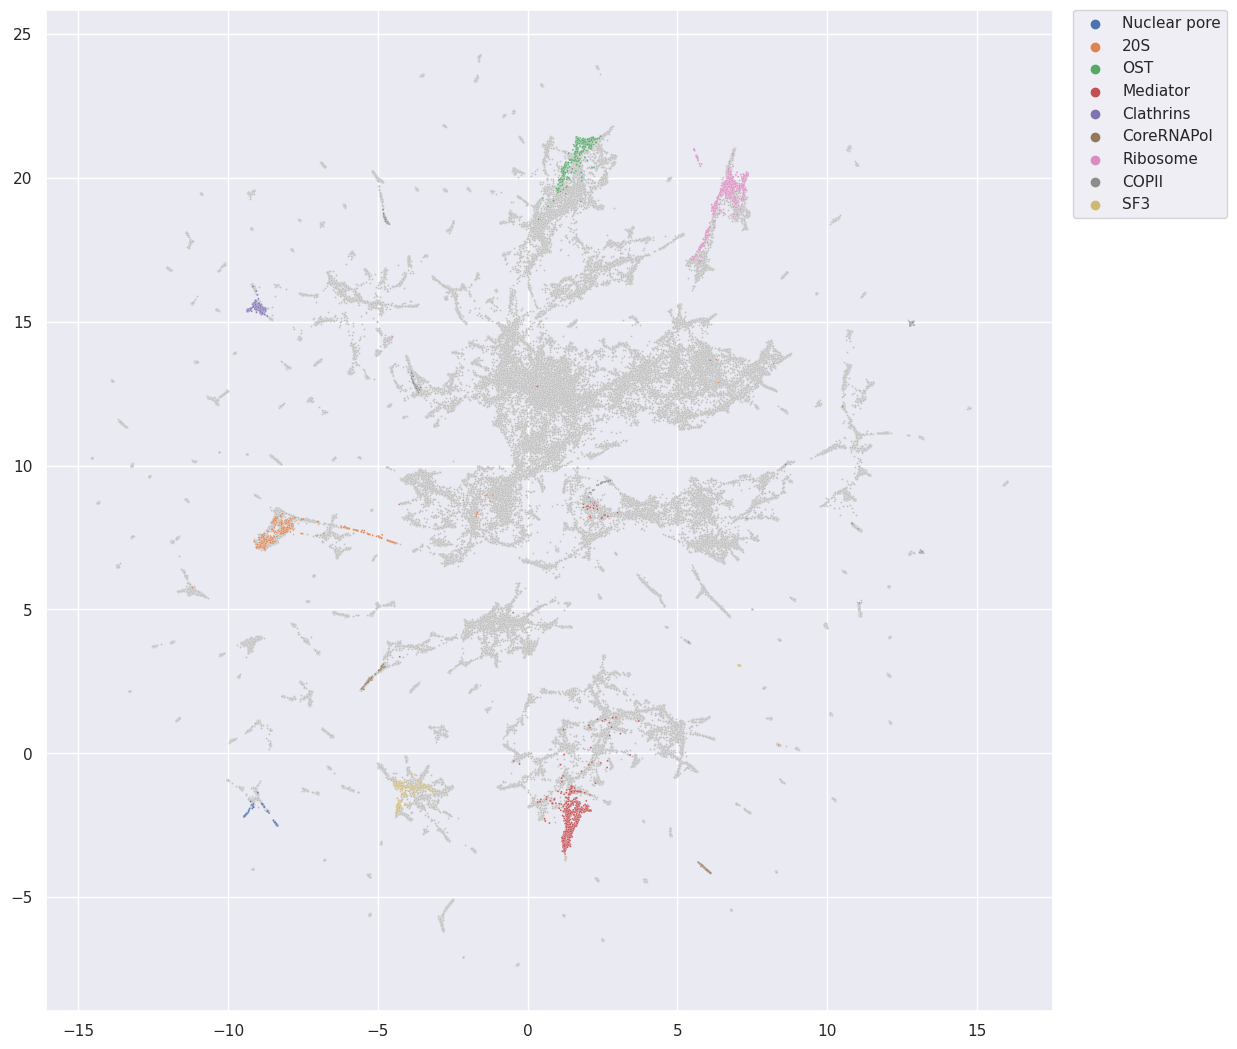

In [12]:
sns.set(rc={"figure.figsize":(13, 13)})
other = complexes_fig == 'other'
sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_embedding[~other, 0], y=reduced_embedding[~other, 1], hue=complexes_fig[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

In [13]:
# sns.set(rc={"figure.figsize":(13, 13)})
# other = complexes_fig != 'Ribosome'
# sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
# re = reduced_embedding[~other]
# n = names[~other]
# p = np.random.permutation(len(n))
# sns.scatterplot(x=re[p, 0], y=re[p, 1], hue=n[p], s=2, alpha=0.9)
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);
# plt.xlim([5, 10])
# plt.ylim([16.5, 21.5])

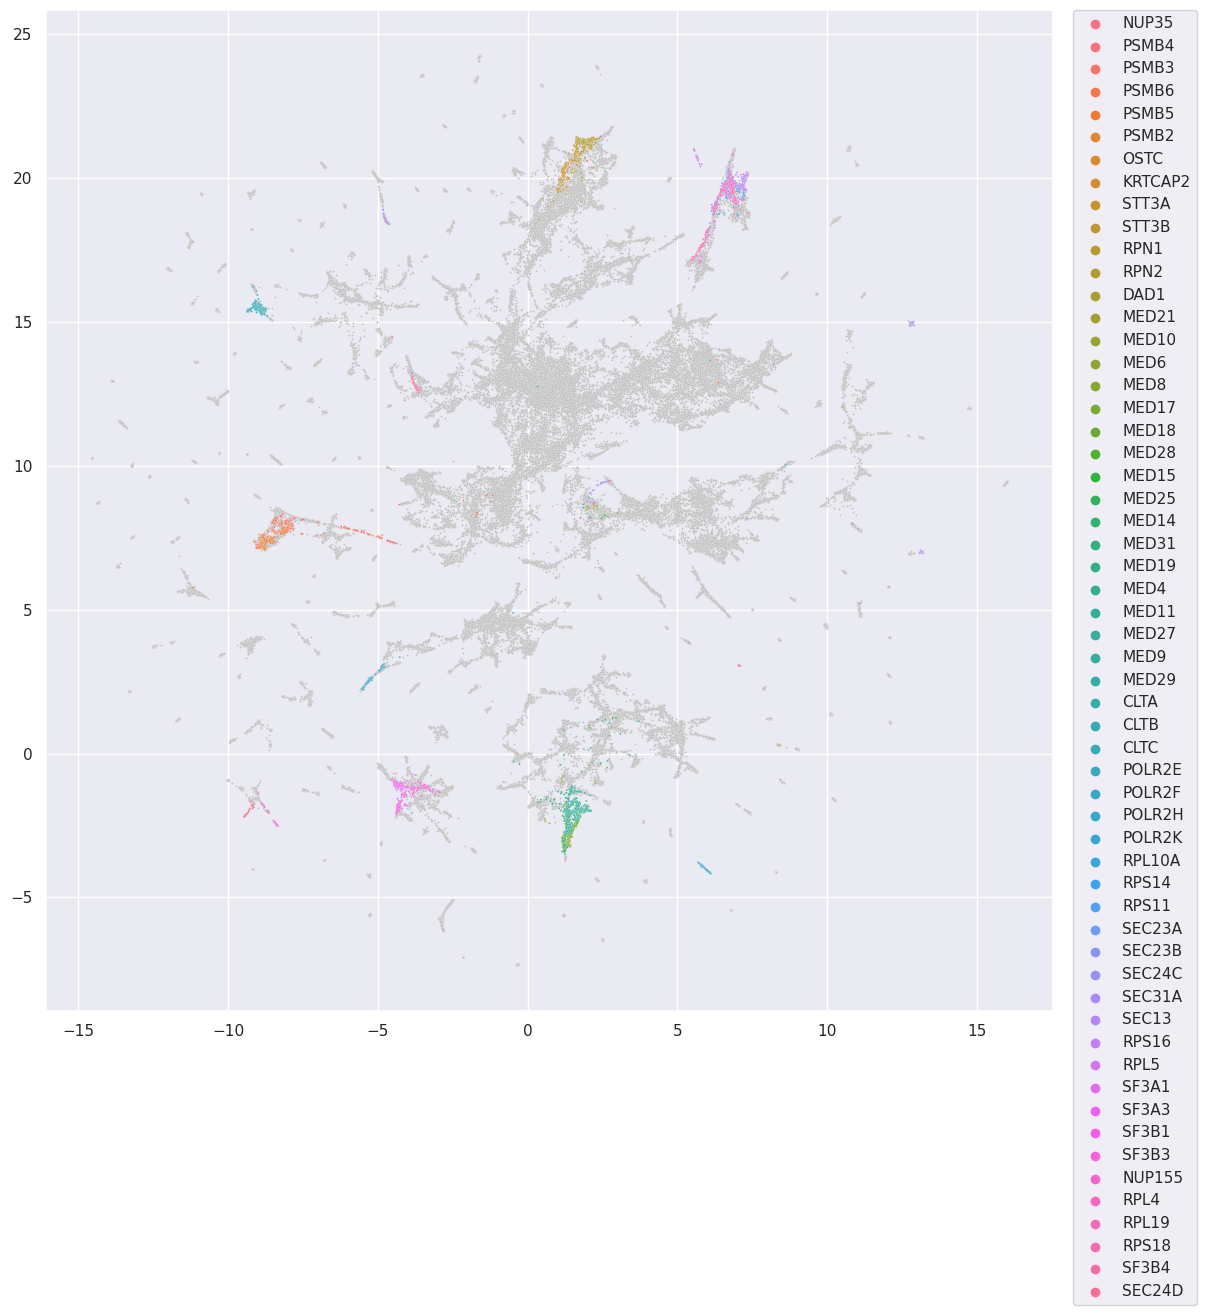

In [14]:
sns.set(rc={"figure.figsize":(13, 13)})
other = complexes_fig == 'other'
sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_embedding[~other, 0], y=reduced_embedding[~other, 1], hue=names[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

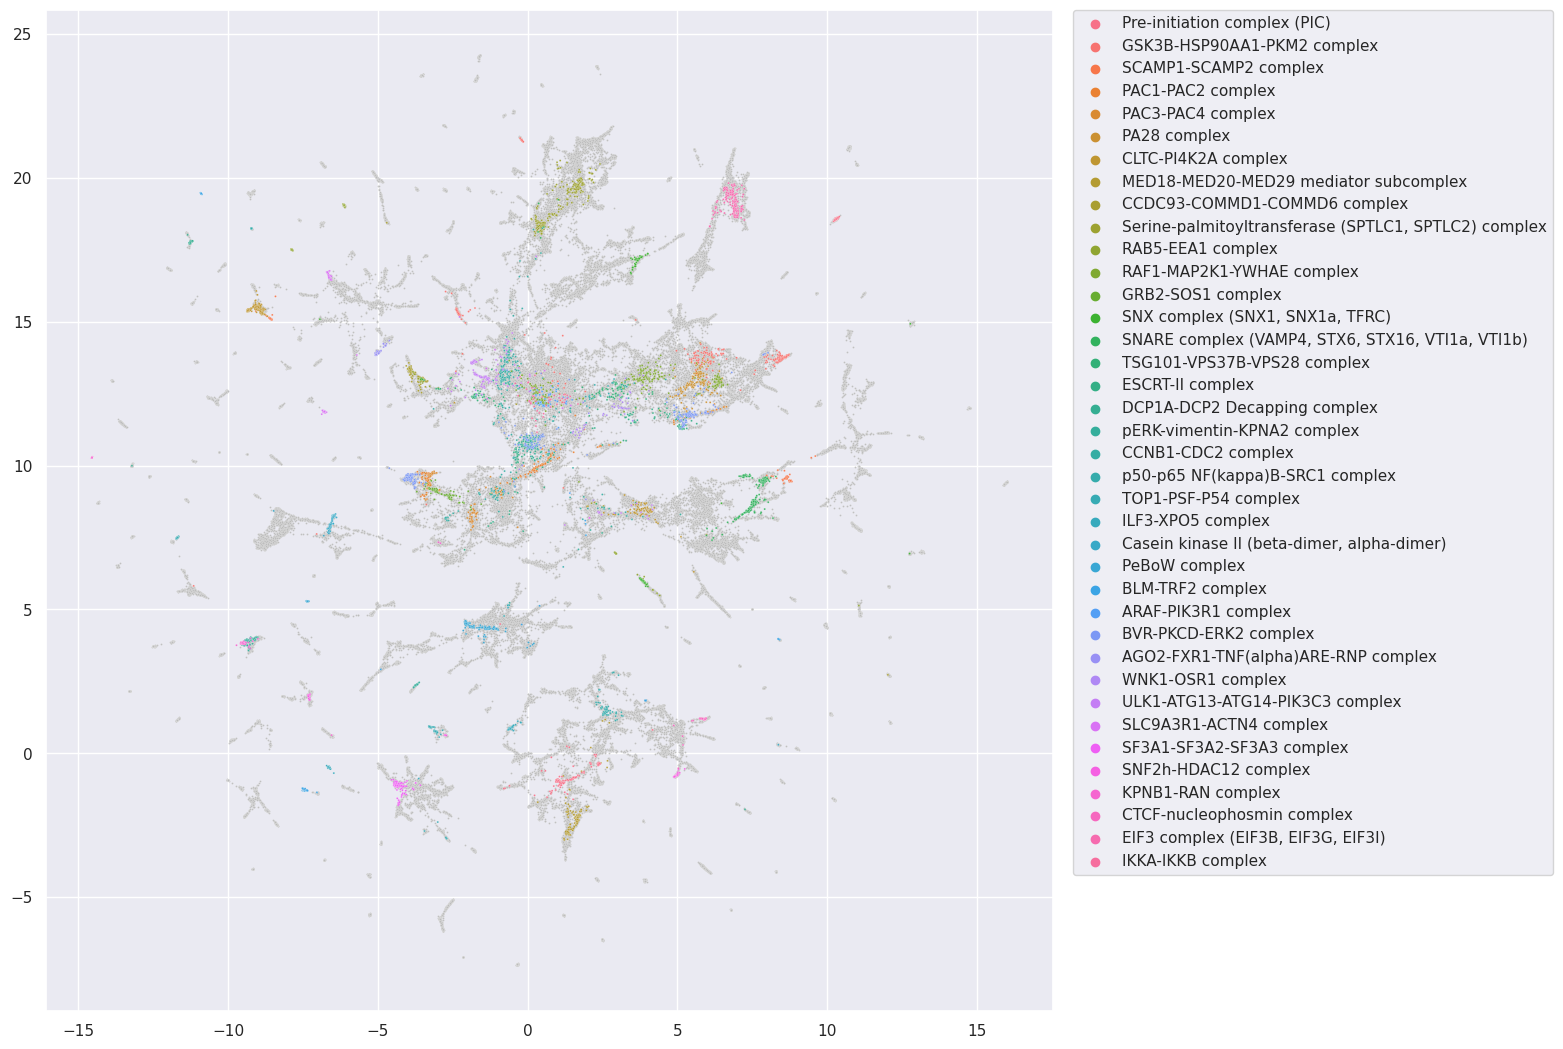

In [15]:
sns.set(rc={"figure.figsize":(13, 13)})
other = complexes == 'other'
sns.scatterplot(x=reduced_embedding[other, 0], y=reduced_embedding[other, 1], color=[188/255, 188/255, 188/255], s=2, alpha=0.9)
sns.scatterplot(x=reduced_embedding[~other, 0], y=reduced_embedding[~other, 1], hue=complexes[~other], s=2, alpha=0.9)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

### Score clustering

In [16]:
def robust_mean(cluster):
    return np.median(cluster, axis=0)


def robust_std(cluster):
    # Compute the median absolute deviation (MAD)
    median = robust_mean(cluster)
    mad = np.median(np.abs(cluster - median), axis=0)
    # A common scaling factor for MAD to approximate standard deviation
    return mad * 1.4826


def clustering_score(clusters):
    means = [robust_mean(cluster) for cluster in clusters]
    stds = [robust_std(cluster) for cluster in clusters]
    
    numerator = robust_std(means)
    denominator = robust_mean(stds)
    
    individual_scores = numerator / denominator
    
    # Assuming that you want to average the individual scores for the final score
    final_score = np.mean(individual_scores)
    
    return final_score

In [17]:
labels = np.unique(localizations)
labels = labels[labels != 'other']
clusters = [reduced_embedding[localizations == label] for label in labels]
print(np.mean([len(c) for c in clusters]))
clustering_score(clusters)

3766.222222222222


3.9869576

In [18]:
labels = np.unique(complexes)
labels = labels[labels != 'other']
clusters = [reduced_embedding[complexes == label] for label in labels]
print(np.mean([len(c) for c in clusters]))
clustering_score(clusters)

164.73684210526315


18.840164

### Logistic regression

In [6]:
from sklearn.linear_model import LogisticRegression

other = localizations_train == 'other'
X_train = embeddings_train[~other]
X_train = X_train.reshape((X_train.shape[0], -1))
y_train = localizations_train[~other]

other = localizations == 'other'
X_test = embeddings[~other]
X_test = X_test.reshape((X_test.shape[0], -1))
y_test = localizations[~other]

In [7]:
np.unique(localizations_train)

array(['ER', 'Golgi', 'cytoplasm', 'mitochondria', 'nuclear_domains',
       'nuclear_membrane', 'nucleolus', 'nucleoplasm', 'other',
       'vesicles'], dtype='<U16')

In [20]:
clf = LogisticRegression(random_state=0, penalty='l2', C=1.0).fit(X_train, y_train)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
y_predict = clf.predict(X_test)

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

class_labels = np.unique(y_train)

acc = accuracy_score(y_test, y_predict)
print(f'Accuracy {acc}')

cm = confusion_matrix(y_test, y_predict, labels=class_labels)
cm_norm = cm / cm.sum(axis=1)[:, None]
cm_df = pd.DataFrame(cm_norm, index=class_labels, columns=class_labels)


Accuracy 0.9724156242624499


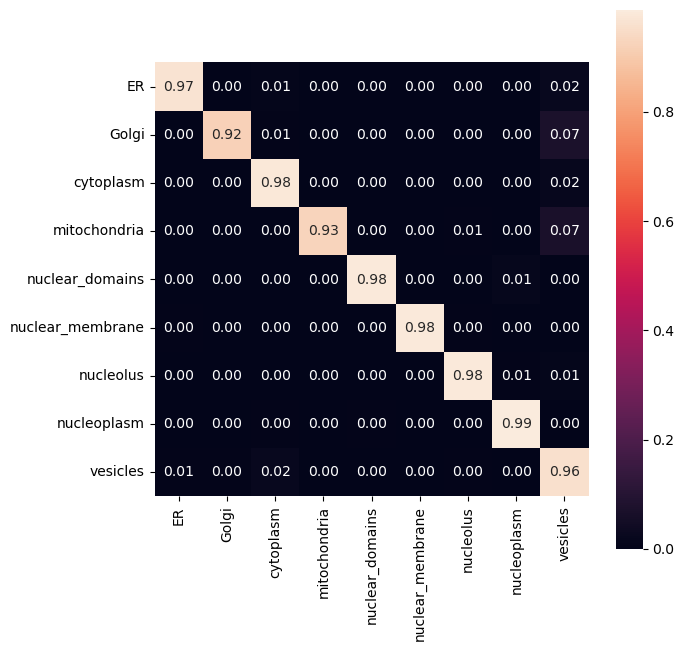

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
sns.heatmap(cm_df, square=True, annot=True, fmt=".2f");


In [28]:
from joblib import dump

# Save the model to a file
dump(clf, 'good_localization_classifier_redo21.joblib')

['good_localization_classifier_c3_redo21.joblib']

In [39]:
from joblib import load

# Load the model from the file
loaded_model = load('good_localization_classifier_redo21.joblib')
